In [1]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [2]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import copy

In [3]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import models.rnn as rnns
import models.mlp as mlps
import models.linear as linears
import control.agents as agents
import control.environments as env
import utils.eligibility_optim as eligibility

# Setup

## Environment


In [6]:
env_name = 'Taxi-v2'

environment = env.Environment(
    environment=gym.make(env_name), 
    agent=None,
    verbose=True,
    max_steps=200,
    capacity=500,
    representation_method='one_hot_encoding',
)

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Model

In [7]:
model_linear = linears.Linear(
    input_dimension=environment.get_input_dimension(), 
    n_actions=environment.n_actions,
)

model_mlp = mlps.MLP(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=100,
    n_hidden_layers=1,
    n_actions=environment.n_actions,
    dropout=0.
)

model_rnn = rnns.RNN(
    input_dimension=environment.get_input_dimension(), 
    hidden_dimension=20,
    n_actions=environment.n_actions,
    dropout=0.,
    truncate=20
)

model_attentive_rnn = rnns.AttentiveRNN(
    input_dimension=environment.get_input_dimension(),
    hidden_dimension=20,
    key_dimension=10,
    n_actions=environment.n_actions,
    dropout=0.,
    horizon=-1,
    truncate=20
)

## Agent

In [8]:
model = model_mlp

agent = agents.DQNAgent(
    model=model,
    optimiser=torch.optim.SGD(model.parameters(), lr=1e-4), 
    gamma=.99, 
    temperature=10,
    algorithm='qlearning',
    n_actions=environment.n_actions,
    terminal_state=environment.max_obs
)

environment.agent = agent

Load an agent:

In [12]:
model.load_state_dict(torch.load('../saved/taxi/mlp/state_dict_saved.pth'))
agent.commit()
print(environment.agent.q(environment.state_representation(479)))

[-107.571175 -106.99925  -105.088844 -107.885025 -115.8059   -113.98003 ]


# Experiment

## Training

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 1/100


100%|###############################################################| 10/10 [00:09<00:00,  1.03s/it]


>> Training return : -769.53


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -1187.75, steps : 200.00
>> Training loss : 33.94
Epoch 2/100


100%|###############################################################| 10/10 [00:14<00:00,  1.59s/it]


>> Training return : -758.93


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -1185.05, steps : 200.00
>> Training loss : 30.78
Epoch 3/100


100%|###############################################################| 10/10 [00:20<00:00,  2.15s/it]


>> Training return : -784.24


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -1097.30, steps : 200.00
>> Training loss : 30.17
Epoch 4/100


100%|###############################################################| 10/10 [00:25<00:00,  2.62s/it]


>> Training return : -757.63


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -916.85, steps : 200.00
>> Training loss : 29.57
Epoch 5/100


100%|###############################################################| 10/10 [00:31<00:00,  3.37s/it]


>> Training return : -776.79


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -738.65, steps : 200.00
>> Training loss : 29.07
Epoch 6/100


100%|###############################################################| 10/10 [00:41<00:00,  4.20s/it]


>> Training return : -775.81


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -468.65, steps : 200.00
>> Training loss : 29.01
Epoch 7/100


100%|###############################################################| 10/10 [00:41<00:00,  4.12s/it]


>> Training return : -750.84


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -1097.30, steps : 200.00
>> Training loss : 28.24
Epoch 8/100


100%|###############################################################| 10/10 [00:41<00:00,  4.14s/it]


>> Training return : -731.81


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -291.80, steps : 200.00
>> Training loss : 27.09
Epoch 9/100


100%|###############################################################| 10/10 [00:37<00:00,  3.83s/it]


>> Training return : -734.40


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -202.25, steps : 200.00
>> Training loss : 23.93
Epoch 10/100


100%|###############################################################| 10/10 [00:38<00:00,  3.90s/it]


>> Training return : -697.89
>> Evaluation return : -203.60, steps : 200.00
>> Training loss : 19.45


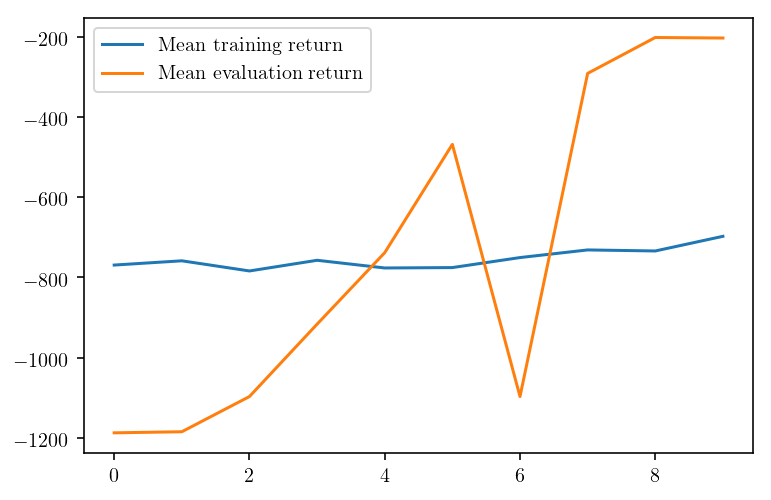

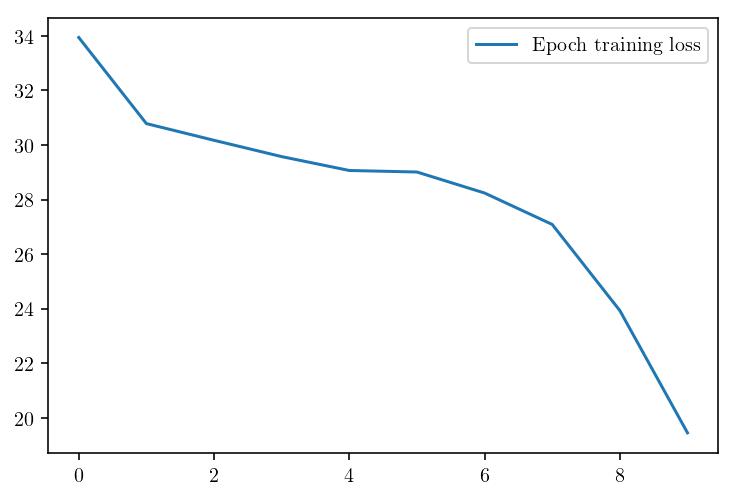

  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Epoch 11/100


100%|###############################################################| 10/10 [00:30<00:00,  2.59s/it]


>> Training return : -616.07


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -200.00, steps : 200.00
>> Training loss : 11.49
Epoch 12/100


100%|###############################################################| 10/10 [00:24<00:00,  2.44s/it]


>> Training return : -526.90


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -202.25, steps : 200.00
>> Training loss : 6.70
Epoch 13/100


100%|###############################################################| 10/10 [00:24<00:00,  2.41s/it]


>> Training return : -479.47


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.35, steps : 200.00
>> Training loss : 4.59
Epoch 14/100


100%|###############################################################| 10/10 [00:23<00:00,  2.36s/it]


>> Training return : -462.25


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -202.70, steps : 200.00
>> Training loss : 4.07
Epoch 15/100


100%|###############################################################| 10/10 [00:24<00:00,  2.47s/it]


>> Training return : -441.38


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

>> Evaluation return : -201.80, steps : 200.00
>> Training loss : 2.53
Epoch 16/100


 10%|######4                                                         | 1/10 [00:02<00:21,  2.44s/it]


KeyboardInterrupt: 

In [11]:
training, evaluation = environment.run(
    epochs=100,
    segments=10,
    episodes=10,
    wall_time=2,
    num_evaluation=20,
    batch_size=100,
    save_directory='../saved/taxi_mlp',
    log_directory='final_taxi_mlp',
    temp_decay = 0.99,
    display_return_curve=True,
)

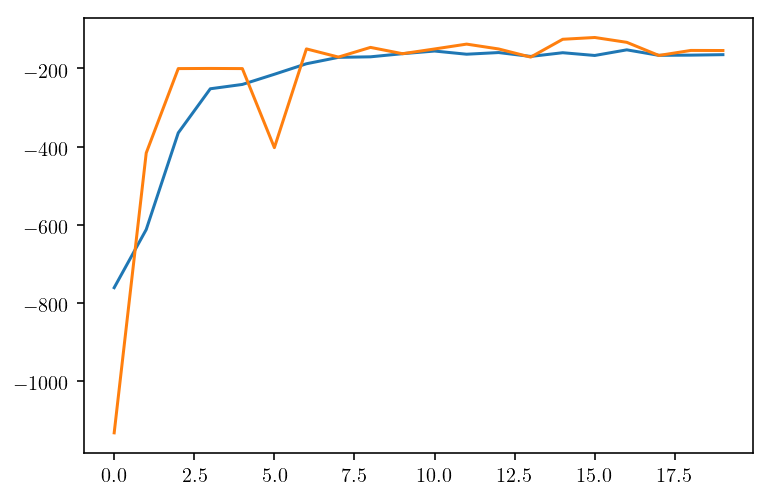

In [13]:
plt.figure()
plt.plot(training)
plt.plot(evaluation)
plt.show()

## Testing

In [14]:
environment.exploration_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 246
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 226
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 126
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 126
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 226
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 206
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 206
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 106
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 106
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 346
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 426
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
State: 326
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | :

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 486
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 466
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 466
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 466
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 366
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |


(-452.0, 200)

In [24]:
environment.evaluation_episode(render=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

State: 294
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
State: 294
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 394
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
State: 494
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 474
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
State: 478
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
State: 378
+---------+
|R: | : :G|
| : : : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
State: 278
+---------+
|R: | : :G|
| : : : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
State: 258
+---------+
|R: | : :G|
| : : : : |
| :_: : : |
| | : | : |
|Y| : 

(8.0, 13)

## Save

In [41]:
environment.agent.save('../saved/taxi/mlp')